In [38]:
! conda install tensorflow -y 

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Retrieving notices: ...working... done


In [39]:
import tensorflow as tf

In [40]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [41]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [42]:
import numpy as np

np.save('data/train_data', x_train)
np.save('data/train_labels', y_train)

np.save('data/eval_data', x_test)
np.save('data/eval_labels', y_test)

In [68]:
import boto3

region = "us-east-1"
bucket_name = "ids721final"

s3_client = boto3.client('s3',region_name = region)
location = {'LocationConstraint' : region}
s3_client.create_bucket(Bucket = bucket_name , CreateBucketConfiguration = location)

ClientError: An error occurred (InvalidLocationConstraint) when calling the CreateBucket operation: The specified location-constraint is not valid

In [47]:
import glob

for filepath in glob.glob("./data/*.npy"):
    s3_client.upload_file(filepath, bucket_name, filepath.replace("./data/", ""))

In [48]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name

In [49]:
training_data_uri = "s3://{}/".format(bucket_name)

In [50]:
metric_definitions = [
        {"Name": "loss", "Regex": "loss: ([0-9\\.]+)"},
        {"Name": "accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
        {"Name": "val_loss", "Regex": "val_loss: ([0-9\\.]+)"},
        {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
    ]

In [51]:
from sagemaker.tensorflow import TensorFlow

cifar_estimator = TensorFlow(
    entry_point="main.py",
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    framework_version="2.1.0",
    py_version="py3",
    metric_definitions=metric_definitions,
    enable_sagemaker_metrics=True,
    distribution={"parameter_server": {"enabled": True}},
    #tags=[{"Key": "trial-desc", "Value": trial_desc}],
)

In [ ]:
cifar_estimator.fit(
    training_data_uri
)

In [63]:
predictor = cifar_estimator.deploy(initial_instance_count=1, instance_type="ml.p2.xlarge")
predictor.endpoint_name

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: tensorflow-training-2023-04-30-12-16-29-750
INFO:sagemaker:Creating endpoint-config with name tensorflow-training-2023-04-30-12-16-29-750
INFO:sagemaker:Creating endpoint with name tensorflow-training-2023-04-30-12-16-29-750


------!

'tensorflow-training-2023-04-30-12-16-29-750'

In [64]:
CIFAR100_LABELS_LIST = [
                        'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
                        'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
                        'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
                        'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
                        'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
                        'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
                        'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
                        'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
                        'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
                        'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
                        'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
                        'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
                        'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
                        'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
                        'worm'
                        ]

In [59]:
! pip install pillow


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [73]:
import json
import numpy as np
import boto3
import io
from PIL import Image
import IPython.display as display

runtime = boto3.Session().client(service_name='sagemaker-runtime')
file_name = ["test1.png", "test2.png", "test3.png", "test4.png", "test5.png"]
endpoint = 'tensorflow-training-2023-04-30-12-16-29-750'

def predict(file_name):
    # Load the image bytes
    f = open(file_name, 'rb').read()
    f = io.BytesIO(f)
    image_view = Image.open(f).convert('RGB')
    batch_size = 1
    image = np.asarray(image_view.resize((32, 32)))
    image = np.concatenate([image[np.newaxis, :, :]] * batch_size)
    body = json.dumps({"signature_name": "serving_default", "instances": image.tolist()})

    # Call your model for predicting which object appears in this image.
    response = runtime.invoke_endpoint(
        EndpointName=endpoint,
        ContentType='application/json', 
        Body=body
    )
    result = response['Body'].read()
    pred = json.loads(result)['predictions'][0]
    index = np.argmax(pred)
    display.display( image_view.resize((128, 128)) ) 
    print("{}% {}".format(int(pred[index]*100), CIFAR100_LABELS_LIST[index]))

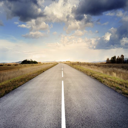

99% road


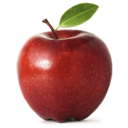

99% apple


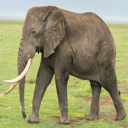

99% elephant


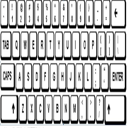

99% keyboard


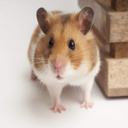

92% hamster


In [75]:
import glob
for file_name in glob.glob("./sample/*"):
    predict(file_name)

In [62]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: tensorflow-training-2023-04-30-11-54-46-681
INFO:sagemaker:Deleting endpoint with name: tensorflow-training-2023-04-30-11-54-46-681
